# Demo of Stable Signature DCGAN on MNIST dataset

Imports

In [1]:
import os.path
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import peak_signal_noise_ratio
from torchvision import transforms

from hidden.models import HiddenDecoder
from stable_signature.models.dcgan import Generator

C:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from argparse import Namespace

params = Namespace(
    encoder_depth=4, encoder_channels=64, decoder_depth=8, decoder_channels=64, num_bits=32,
    z_dim=100, device='cuda'
)
params.device = torch.device(params.device)

G0 = Generator(1, params.z_dim)
G = deepcopy(G0)

decoder = HiddenDecoder(
    num_blocks=params.decoder_depth,
    num_bits=params.num_bits,
    channels=params.decoder_channels,
    in_channels=1,
)

In [6]:
project_root = os.path.dirname(os.path.dirname(os.path.abspath('')))

# load_state_dict
G0.load_state_dict(torch.load(
    os.path.join(project_root, 'ckpts/dcgan_generator_mnist.pth'), weights_only=False, map_location='cpu'))
G0.to(params.device).eval()

G.load_state_dict(torch.load(
    os.path.join(project_root, 'stable_signature/outputs/mnist_attack/checkpoint_000.pth'), weights_only=False, map_location='cpu')['generator'])
G.to(params.device).eval()
with open(os.path.join(project_root, 'stable_signature/outputs/mnist_attack/keys.txt'), 'r') as f:
    # read key
    G_key = f.readline().strip().split()[-1]

state_dict = torch.load(os.path.join(project_root, 'ckpts/hidden_mnist_unet.pth'), weights_only=False, map_location='cpu')[
    'encoder_decoder']
decoder_state_dict = {k.replace('module.', '').replace('decoder.', ''): v for k, v in state_dict.items() if 'decoder' in k}
decoder.load_state_dict(decoder_state_dict)
decoder.to(params.device).eval()

HiddenDecoder(
  (layers): Sequential(
    (0): ConvBNRelu2d(
      (layers): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (1): ConvBNRelu2d(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (2): ConvBNRelu2d(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (3): ConvBNRelu2d(
      (layers): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### Generate Images

In [11]:
to_img = transforms.Compose([
    transforms.Normalize(mean=(-1.,), std=[2.0, ]),
    transforms.Lambda(lambda x: x.detach().cpu().squeeze(0)),
    transforms.ToPILImage(),
])

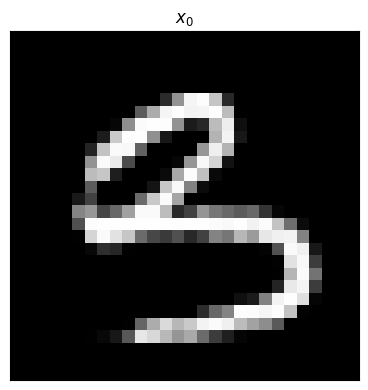

In [14]:
# generate random image
z = torch.randn(1, params.z_dim, 1, 1, device=params.device)
x0 = G0(z)
img = to_img(x0)

# visualize
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)
ax.grid('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('$x_0$')

fig.tight_layout()
plt.show()

### Tests

In [39]:
from termcolor import colored


def msg2str(m: torch.Tensor) -> str:
    return ''.join([('1' if el else '0') for el in m.detach().cpu().bool()])


def str2msg(m_str: str, device=None) -> torch.Tensor:
    return torch.tensor([True if el == '1' else False for el in m_str], device=device)


def colored_repr(k_hat, k):
    return ''.join([colored(k_hat[i], 'green' if k_hat[i] == k[i] else 'red') for i in range(len(k))])


m_ori = torch.tensor(list(map(int, G_key)), dtype=torch.bool, device=params.device)

PSNR: 21.31201
Message: 11101011010100000101011101001101
Decoded: 11101011010100000111011101001101
Bit Accuracy: 0.96875


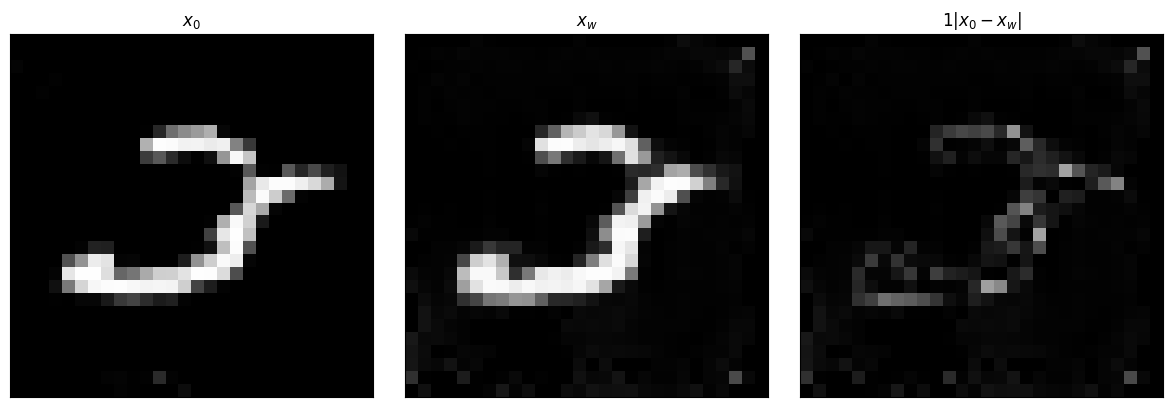

In [44]:
# load random image
z = torch.randn(1, params.z_dim, 1, 1, device=params.device)
x0 = G0(z)
img = to_img(x0)

# encode
x_w = G(z)
img_w = to_img(x_w)

# psnr
psnr = peak_signal_noise_ratio(np.asarray(img), np.asarray(img_w))
print(f'PSNR: {psnr:.05f}')

# decode
m_hat = decoder(x_w)
m_decoded = m_hat > 0  # b k -> b k
print(f'Message: {G_key}')
print(f'Decoded: {colored_repr(msg2str(m_decoded.squeeze(0)), G_key)}')
print(f'Bit Accuracy: {torch.eq(m_decoded, m_ori).sum().item() / params.num_bits:.05f}')

# visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()
axes[0].imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)
axes[0].grid('off')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('$x_0$')

axes[1].imshow(np.asarray(img_w), cmap='gray', vmin=0, vmax=255)
axes[1].grid('off')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('$x_w$')

magnitude = 1
diff_img = np.abs(np.asarray(img).astype(int) - np.asarray(img_w).astype(int)) * magnitude
diff_img = np.clip(diff_img, 0, 255).astype(np.uint8)
axes[2].imshow(diff_img, cmap='gray', vmin=0, vmax=255)
axes[2].grid('off')
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title(f'${magnitude}|x_0 - x_w|$')

fig.tight_layout()
plt.show()